In [135]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import ipywidgets as widgets

from pyvis.network import Network
import networkx as nx

import pandas as pd

import uuid
import random

import time

from ipywidgets import widgets  
from ipywidgets import Button, Layout

### Make toy data

In [136]:
countries = ['CHN', 'IND', 'USA', 'IDN', 'PAK', 'BRA', 'NGA', 'BGD', 'RUS', 'JPN', 'MEX', 'ETH', 'PHL', 
 'EGY', 'VNM', 'COD', 'DEU', 'TUR', 'IRN', 'THA', 'FRA', 'GBR', 'ITA', 'ZAF', 'TZA', 'MMR', 
 'KOR', 'KEN', 'COL', 'ESP', 'UKR', 'ARG', 'UGA', 'DZA', 'SDN', 'IRQ', 'POL', 'AFG', 'CAN', 
 'MAR', 'SAU', 'UZB', 'PER', 'MYS', 'AGO', 'GHA', 'MOZ', 'VEN', 'YEM', 'NPL', 'MDG', 'PRK', 
 'CMR', 'CIV', 'AUS', 'TWN', 'NER', 'LKA', 'BFA', 'ROU', 'MLI', 'CHL', 'KAZ', 'MWI', 'ZMB', 
 'GTM', 'NLD', 'ECU', 'SYR', 'KHM', 'SEN', 'TCD', 'SOM', 'ZWE', 'GIN', 'RWA', 'TUN', 'BEN', 
 'BEL', 'BOL', 'CUB', 'BDI', 'HTI', 'GRC', 'DOM', 'CZE', 'PRT', 'SWE', 'JOR', 'AZE', 'HUN', 
 'ARE', 'HND', 'BLR', 'TJK', 'ISR', 'AUT', 'PNG', 'CHE']

poss_tags = ['Science', 'Technology', 'Religion', 'Politics', 'Food', 'Finance']

In [137]:
tags = [list(set([random.choice(poss_tags) for x in range(1,random.choice(range(2,len(poss_tags))))])) for y in range(0,100)]
country_tags = [list(set([random.choice(countries) for x in range(1,random.choice(range(2,10)))])) for y in range(0,100)]
GUIDs = [str(uuid.uuid4()) for x in range(0,100)]

In [225]:
# Generate Nodes
df_nodes = pd.DataFrame(data=[GUIDs, tags, country_tags]).transpose().rename(columns={0:'GUID', 1:'Tags', 2:'Countries'})

In [226]:
# Generate Edges
allrows = []
for i in range(0,25):
    row = [random.choice(df_nodes['GUID']), random.choice(df_nodes['GUID'])]
    allrows.append(row)

for row in allrows:
    if row[0]==row[1]:
        allrows.remove(row)
print(len(allrows))
df_edges = pd.DataFrame(allrows).rename(columns={0:'Source', 1:'Target'})

25


In [227]:
df_nodes['GUID'].nunique()

100

In [228]:
df_edges['Source'].nunique()

23

In [141]:
df_nodes.head()

,GUID,Tags,Countries
0,c1990273-50ae-42a0-a8f1-7569932d9300,"[Food, Technology]","[AFG, BGD, SAU, BFA, GHA, FRA, ECU]"
1,232ed736-ef89-4c2d-bb96-8e53b40052fa,"[Food, Religion, Science]","[EGY, PHL, DOM, KHM, ESP, ZWE, ETH, YEM]"
2,28a126f7-eef1-4b69-9fe9-a565ae155558,[Politics],"[MEX, HTI, JPN, DOM, NGA]"
3,0852ddd9-d630-4f25-b7e0-6168e711df4a,"[Food, Science]","[AFG, VEN]"
4,5c9c962d-6b2a-4084-af3b-dd255003d393,"[Politics, Technology]","[CHE, VEN, CZE]"


In [142]:
df_edges.head()

,Source,Target
0,c1dc477d-5982-4efe-9621-fb5369b6fb5f,3e75e8e8-8c9f-406b-9881-13b7f7b58a99
1,a8053358-2fa9-4ef1-b323-17bb55afd4f6,49bfef14-f944-41d1-bafb-fed6a7c40309
2,9679f067-e77d-411c-98bb-b6f4d625dbc5,ae7ac9dc-6a36-41e7-a0e1-8908b43694ff
3,0bf54667-827e-433a-87a2-abd8c8a2b096,1f64491e-952e-4e43-855a-fb4a3beec3ac
4,6642b065-13f9-4b4b-8f73-3ef5f5ba8236,961c5ebf-a388-40b1-8791-ac851c6c06f6


------
### Input Widget


In [144]:
df_nodes['Tags'].explode().unique()

array(['Food', 'Technology', 'Religion', 'Science', 'Politics', 'Finance'],
      dtype=object)

In [157]:
Tagpicker = widgets.SelectMultiple(
    options=df_nodes['Tags'].explode().unique(),
#     value='macOS',
    # rows=10,
    description='Select Tag:',
#     layout=Layout(width="100%"),
    layout=Layout(display="flex", flex_flow='column'),
    disabled=False
)
Tagpicker

SelectMultiple(description='Select Tag:', layout=Layout(display='flex', flex_flow='column'), options=('Food', …

In [335]:
def make_DFs():
    guidmask = df_nodes.explode('Tags')[df_nodes.explode('Tags')['Tags'].isin(Tagpicker.value)]['GUID']

    df_selected_nodes = df_nodes[df_nodes['GUID'].isin(guidmask)]

    df_selected_edges = df_edges[df_edges['Source'].isin(df_selected_nodes['GUID'])]

    ## Confusing name; This is just the nodes you'd need to create the graph based on the selected edges
    df_nodes_SelGraph = df_nodes[df_nodes['GUID'].isin(set(df_selected_edges['Source'].tolist() + df_selected_edges['Target'].tolist()))]

    citers = df_nodes[df_nodes['GUID'].isin(df_selected_edges['Source'])]

    cited = df_nodes[df_nodes['GUID'].isin(df_selected_edges['Target'])]
    
    #     print(len(df_selected_edges['Source'].tolist() + df_selected_edges['Target'].tolist()))
    #     print(len(set(df_selected_edges['Source'].tolist() + df_selected_edges['Target'].tolist())))
    
    return df_selected_nodes, df_selected_edges, df_nodes_SelGraph, citers, cited

In [323]:
make_DFs()

-----
### Build Graph & Vis

In [338]:
G = nx.from_pandas_edgelist(make_DFs()[1], source='Source', target='Target')

In [339]:
def make_vis(name=f'graph {" ".join(Tagpicker.value)} {time.strftime("%d%b%y %H %M %S")}.html', notebook=False):
    if notebook:
        # Specify pixels so you can see the graph in Jupyter
        nt = Network(width="75%", height='500px', directed=True, notebook=notebook)
    else:
        # Make it the size of your screen
        nt = Network(width="75%", height='100%', directed=True, notebook=notebook)
    nt.show_buttons(filter_=['layout','physics'])
    nt.toggle_physics(False) 
    # nt.show_buttons(False)
    nt.width="75%"
    nt.from_nx(G)

    return nt.show(name)

In [340]:
make_vis(notebook=True)

#### Notes 
- you can build the graph with nt.add_nodes(list list list), to preserve attributes
- Consider making groups as a group argument in pyvis, and a categorical in Pandas

------

### Figure out horizontal bar charts

In [126]:
df_select_nodes_tags = pd.DataFrame(df_nodes[df_nodes['GUID'].isin(df_edges['Target'])].explode('Tags')['Tags'].value_counts())
df_select_nodes_tags['pct'] = df_select_nodes_tags['Tags'] / sum(df_select_nodes_tags['Tags'])
df_select_nodes_tags

,Tags,pct
Finance,14,0.297872
Science,8,0.170213
Politics,7,0.148936
Food,7,0.148936
Technology,6,0.127660
Religion,5,0.106383


- https://stackoverflow.com/questions/61740434/how-to-make-horizontal-bar-chart-using-seaborn-to-be-stacked-to-a-100-by-hue-pa
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html

<AxesSubplot:>

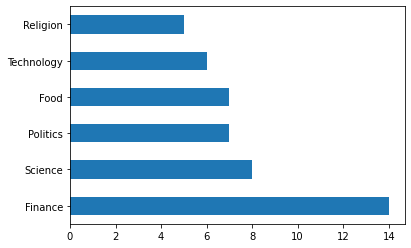

In [82]:
df_nodes[df_nodes['GUID'].isin(df_edges['Target'])].explode('Tags')['Tags'].value_counts().plot(kind='barh', stacked=True)